In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

%matplotlib inline

In [2]:
dataset_dir = '/mnt/d/DataSets/whiteboard_class_cutter/'
data_yaml = dataset_dir + '/data.yaml'

In [16]:
model = YOLO("yolov8s.pt")

In [17]:
model = YOLO("yolov8m.pt")

In [18]:
results = model.train(
    data=str(data_yaml),
    epochs=40,
    imgsz=768,
    batch=4,
    device="cuda",
    workers=6,
    cache=True,
    amp=True,
    patience=7,
    name="whiteboard_det_m_bd_40768"
)

print(f'Обучение завершено. Путь сохранения: {results.save_dir}')

New https://pypi.org/project/ultralytics/8.4.7 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.240 🚀 Python-3.12.3 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/mnt/d/DataSets/whiteboard_class_cutter//data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False,

In [2]:
weights = 'runs/detect/whiteboard_det_m_bd_40768/weights/best.pt' 
model = YOLO(str(weights))

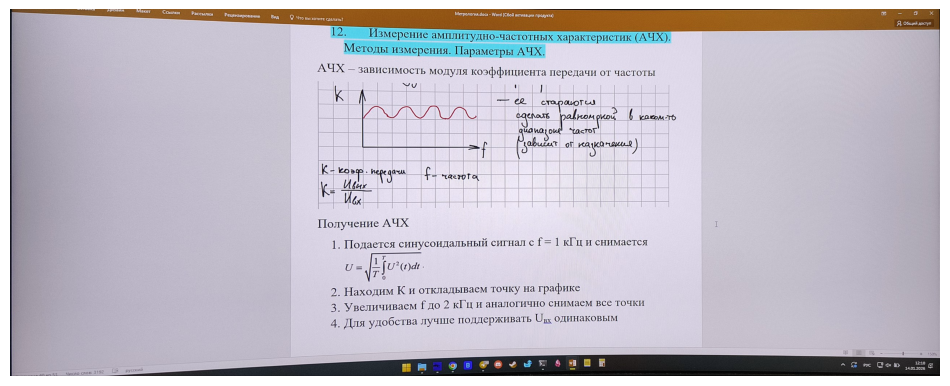

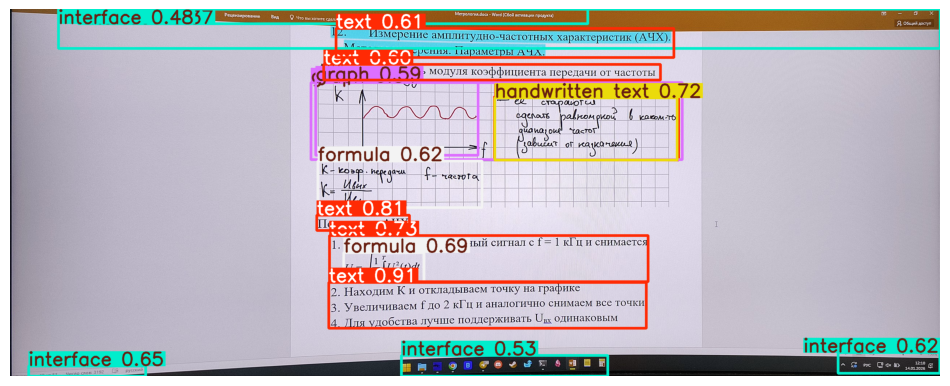

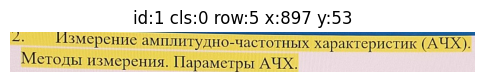

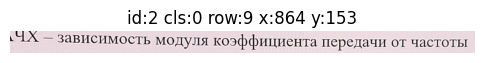

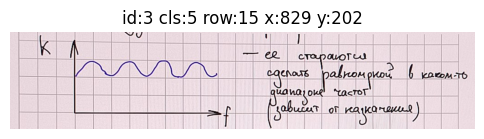

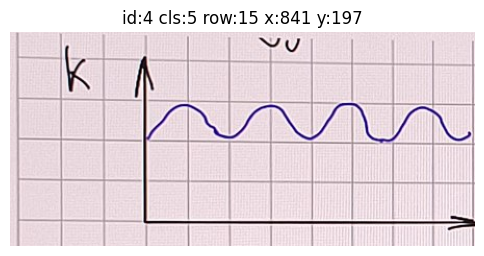

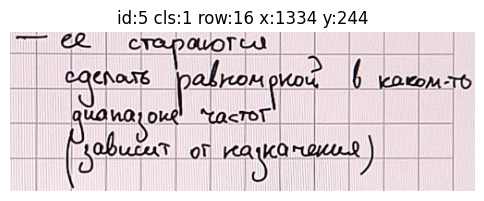

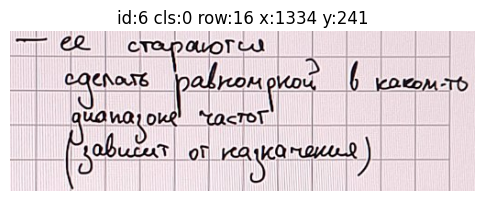

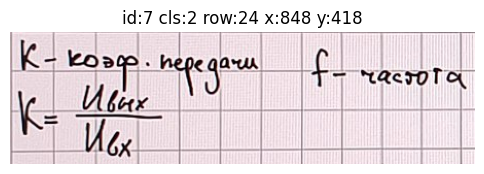

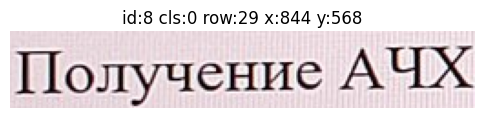

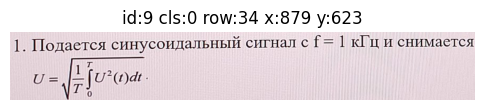

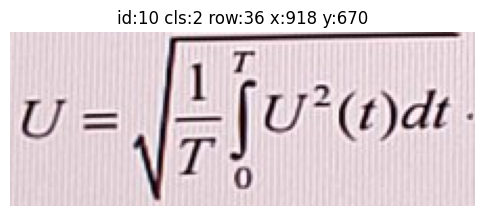

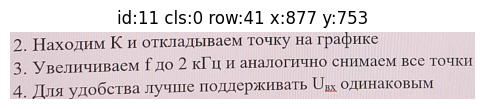

In [31]:
img_path = 'tests/экран метрология word.jpg'
img = cv2.imread(img_path)

pred = model.predict(
    source=img,
    conf=0.3,
    iou=0.5,
    device="cuda",
    save=False,
    verbose=False
)[0]

res = pred.plot()

plt.figure(figsize=(12, 7))
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 7))
plt.imshow(res)
plt.axis('off')
plt.show()


xyxy = pred.boxes.xyxy.cpu().numpy()
cls  = pred.boxes.cls.cpu().numpy().astype(int)

# 0: 'text', 1: 'handwritten text', 2: 'formula', 3: 'scheme', 4: 'image', 5: 'graph', 6: 'table', 7: 'interface'
target_cls = (0, 1, 2, 3, 4, 5, 6)

h, w = img.shape[:2]

line_tol = max(12, int(0.02 * h))

items = []
for b, c in zip(xyxy, cls):
    if c not in target_cls:
        continue

    x1, y1, x2, y2 = b.tolist()

    x1i = max(0, min(w - 1, int(round(x1))))
    y1i = max(0, min(h - 1, int(round(y1))))
    x2i = max(0, min(w,     int(round(x2))))
    y2i = max(0, min(h,     int(round(y2))))
    if x2i <= x1i or y2i <= y1i:
        continue

    yc = 0.5 * (y1i + y2i)
    row = int(round(yc / line_tol))

    items.append((row, x1i, y1i, x2i, y2i, c))

items.sort(key=lambda t: (t[0], t[1]))

for idx, (row, x1i, y1i, x2i, y2i, c) in enumerate(items, start=1):
    crop = img[y1i:y2i, x1i:x2i]

    plt.figure(figsize=(6, 4))
    plt.title(f"id:{idx} cls:{c} row:{row} x:{x1i} y:{y1i}")
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()